# World Cup Event Plots

Visualizing GDP levels and YoY growth around World Cup events:
- **Winners**: Countries that won the World Cup (±16 quarters around the win)
- **Hosts**: Countries that hosted the World Cup (±16 quarters around the event)

Features: GDP, Private Consumption, Government Consumption, Investment (Capital Formation), Exports, Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

pd.set_option('display.max_columns', None)

# Create output folders
EVENT_STUDY_DIR = '../event_study_plots'
DESCRIPTIVE_DIR = '../descriptive_plots'
os.makedirs(EVENT_STUDY_DIR, exist_ok=True)
os.makedirs(DESCRIPTIVE_DIR, exist_ok=True)
print(f"Event study plots: {os.path.abspath(EVENT_STUDY_DIR)}/")
print(f"Descriptive plots: {os.path.abspath(DESCRIPTIVE_DIR)}/")


Plots will be saved to: ../mello_paper_replication/event_study_plots/


In [2]:
# Load data
df = pd.read_csv('../../Data/mello_paper_replication/paper_replication_event_study_sample.csv')

# All features to plot: (level_col, yoy_col, display_name)
FEATURES = [
    ('gdp',                    'gdp_yoy_log_4q',                    'GDP'),
    ('private_consumption',    'private_consumption_yoy_log_4q',    'Private Consumption'),
    ('government_consumption', 'government_consumption_yoy_log_4q', 'Government Consumption'),
    ('capital_formation',      'capital_formation_yoy_log_4q',      'Investment'),
    ('exports',                'exports_yoy_log_4q',                'Exports'),
    ('imports',                'imports_yoy_log_4q',                'Imports'),
]

# Default GDP columns (used in single-feature plots)
gdp_col = 'gdp'
yoy_col = 'gdp_yoy_log_4q'

# tq (time-quarter index) is already in the CSV
df = df.sort_values(['country', 'tq'])

print(f"Loaded {len(df):,} rows, {df['country'].nunique()} countries")
print(f"\nFeatures to plot: {[f[2] for f in FEATURES]}")
print(f"Columns: {list(df.columns)}")

Loaded 8,633 rows, 48 countries

Features to plot: ['GDP', 'Private Consumption', 'Government Consumption', 'Investment', 'Exports', 'Imports']
Columns: ['country', 'quarter', 'gdp', 'private_consumption', 'government_consumption', 'capital_formation', 'exports', 'imports', 'population', 'host', 'rank1', 'rank2', 'rank3', 'rank4', 'host_won', 'host_top4', 'year', 'qtr', 'q_index', 'gdp_yoy_log_4q', 'private_consumption_yoy_log_4q', 'government_consumption_yoy_log_4q', 'capital_formation_yoy_log_4q', 'exports_yoy_log_4q', 'imports_yoy_log_4q', 'population_yoy_log_4q', 'gdp_yoy_pct', 'private_consumption_yoy_pct', 'government_consumption_yoy_pct', 'capital_formation_yoy_pct', 'exports_yoy_pct', 'imports_yoy_pct', 'population_yoy_pct', 'tq', 'winner']


## Define World Cup Events

In [3]:
# World Cup winners (country, year, event quarter = Q2)
winners = [
    ('GBR', 1966, 'England 1966'),
    ('DEU', 1974, 'Germany 1974'),
    ('ARG', 1978, 'Argentina 1978'),
    ('ITA', 1982, 'Italy 1982'),
    ('ARG', 1986, 'Argentina 1986'),
    ('DEU', 1990, 'Germany 1990'),
    ('BRA', 1994, 'Brazil 1994'),
    ('FRA', 1998, 'France 1998'),
    ('BRA', 2002, 'Brazil 2002'),
    ('ITA', 2006, 'Italy 2006'),
    ('ESP', 2010, 'Spain 2010'),
    ('DEU', 2014, 'Germany 2014'),
    ('FRA', 2018, 'France 2018'),
]

# World Cup hosts
hosts = [
    ('GBR', 1966, 'England 1966'),
    ('MEX', 1970, 'Mexico 1970'),
    ('DEU', 1974, 'Germany 1974'),
    ('ARG', 1978, 'Argentina 1978'),
    ('ESP', 1982, 'Spain 1982'),
    ('MEX', 1986, 'Mexico 1986'),
    ('ITA', 1990, 'Italy 1990'),
    ('USA', 1994, 'USA 1994'),
    ('FRA', 1998, 'France 1998'),
    ('JPN', 2002, 'Japan 2002'),
    ('KOR', 2002, 'Korea 2002'),
    ('DEU', 2006, 'Germany 2006'),
    ('ZAF', 2010, 'South Africa 2010'),
    ('BRA', 2014, 'Brazil 2014'),
    ('RUS', 2018, 'Russia 2018'),
]

print(f"Winners: {len(winners)} events")
print(f"Hosts: {len(hosts)} events")

Winners: 13 events
Hosts: 15 events


## Plotting Function

In [4]:
def plot_event(df, country, year, title, level_col, yoy_col, window=16, save_path=None):
    """
    Plot a macro feature level and Δ4 log growth around a World Cup event.
    
    Parameters:
    - country: ISO3 country code
    - year: World Cup year
    - title: Plot title
    - level_col: column name for the level series
    - yoy_col: column name for the Δ4 log growth series
    - window: quarters before/after event (default ±16)
    - save_path: if provided, save figure to this path
    """
    # Event quarter (Q2 of WC year)
    event_tq = year * 4 + 2
    
    # Filter country data
    country_df = df[df['country'] == country].copy()
    
    if len(country_df) == 0:
        print(f"No data for {country}")
        return None
    
    # Calculate relative time
    country_df['rel_time'] = country_df['tq'] - event_tq
    
    # Filter to window
    plot_df = country_df[(country_df['rel_time'] >= -window) & (country_df['rel_time'] <= window)].copy()
    
    if len(plot_df) < 5:
        print(f"Insufficient data for {title}")
        return None
    
    # Create figure with dual y-axis
    fig, ax1 = plt.subplots(figsize=(12, 5))
    
    # Level (left axis) - scale to billions
    level_billions = plot_df[level_col] / 1e6  # Convert to billions
    color1 = 'steelblue'
    ax1.plot(plot_df['rel_time'], level_billions, 'o-', color=color1, linewidth=2, markersize=4, label=f'{level_col} Level')
    ax1.set_xlabel('Quarters relative to World Cup (q=0 at Q2)', fontsize=11)
    ax1.set_ylabel(f'{level_col.replace("_", " ").title()} (billions USD PPP)', color=color1, fontsize=11)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    # Δ4 log growth (right axis)
    ax2 = ax1.twinx()
    color2 = 'coral'
    ax2.plot(plot_df['rel_time'], plot_df[yoy_col], 's--', color=color2, linewidth=2, markersize=4, label='Δ4 log Growth')
    ax2.set_ylabel('Δ4 log Growth', color=color2, fontsize=11)
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    
    # World Cup marker (dashed vertical line at q=0)
    ax1.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='World Cup')
    
    # Shade post-treatment region
    ax1.axvspan(0, window, alpha=0.05, color='red')
    
    # Title and legend
    ax1.set_title(f'{title}', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(-window, window+1, 4))
    ax1.grid(True, alpha=0.3)
    
    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    return fig

## World Cup Winners

WORLD CUP WINNERS: GDP and YoY Growth (±16 quarters)
Saved: ../mello_paper_replication/event_study_plots\winner_GBR_1966.png


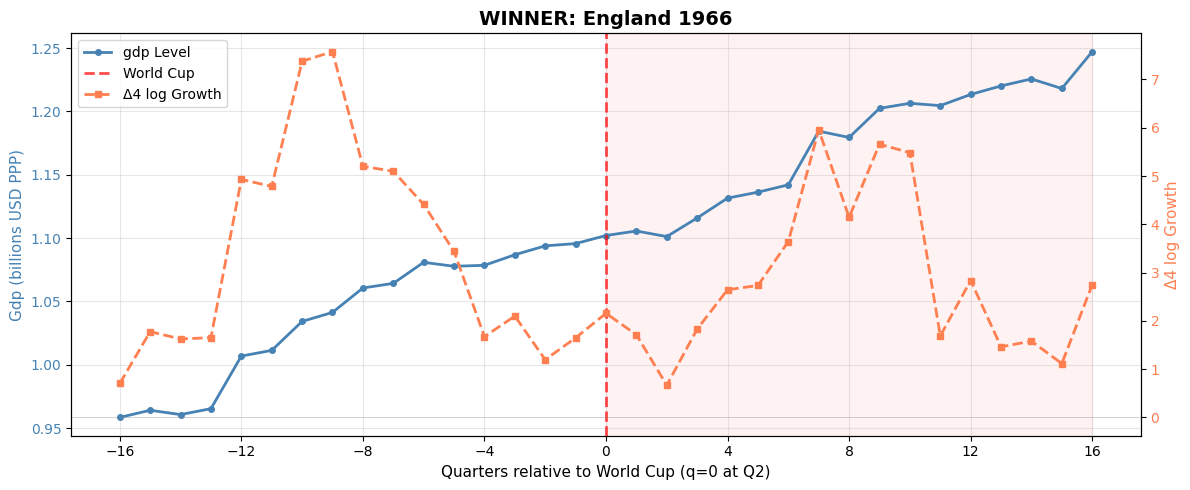


Saved: ../mello_paper_replication/event_study_plots\winner_DEU_1974.png


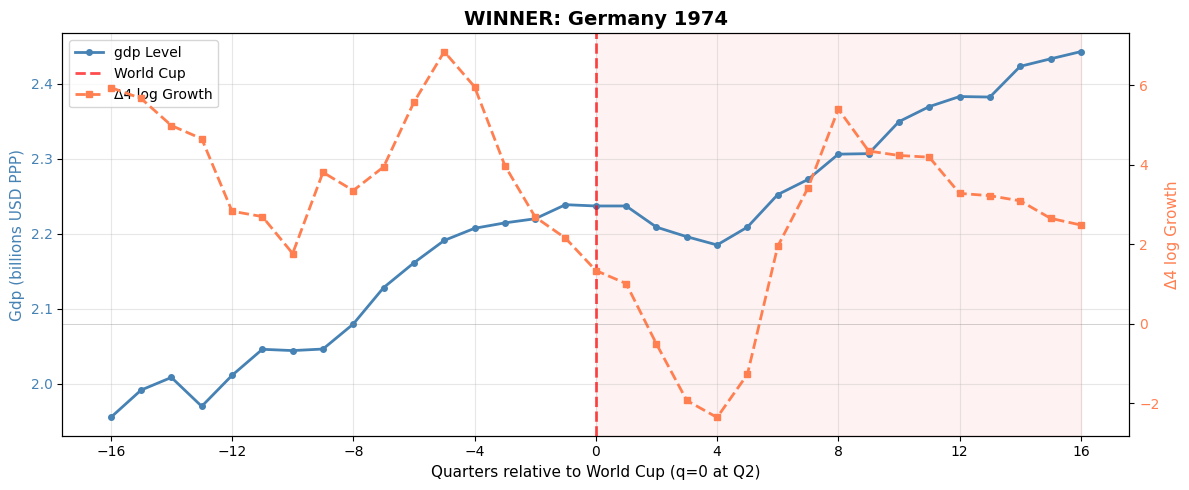


Insufficient data for WINNER: Argentina 1978

Saved: ../mello_paper_replication/event_study_plots\winner_ITA_1982.png


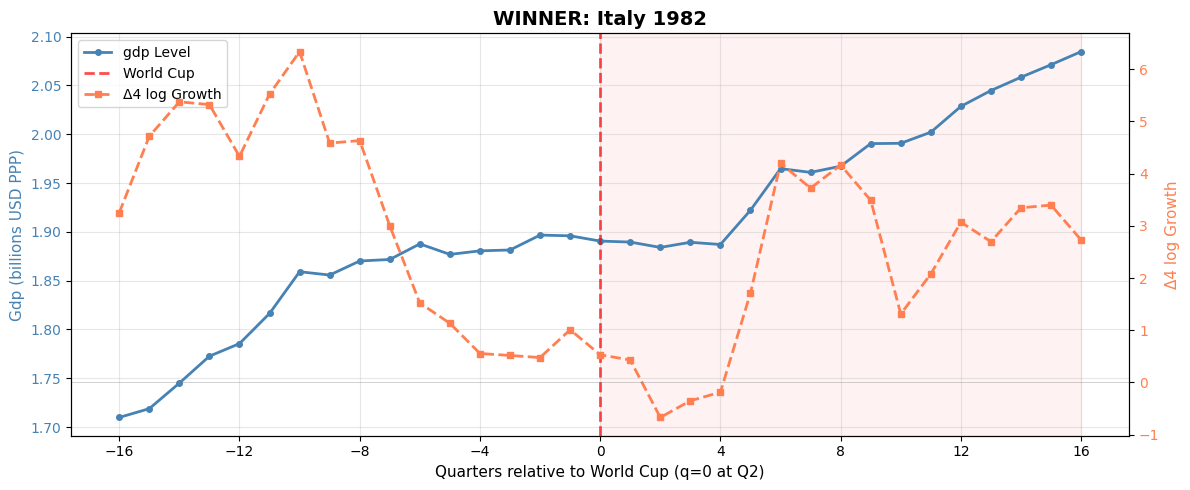


Insufficient data for WINNER: Argentina 1986

Saved: ../mello_paper_replication/event_study_plots\winner_DEU_1990.png


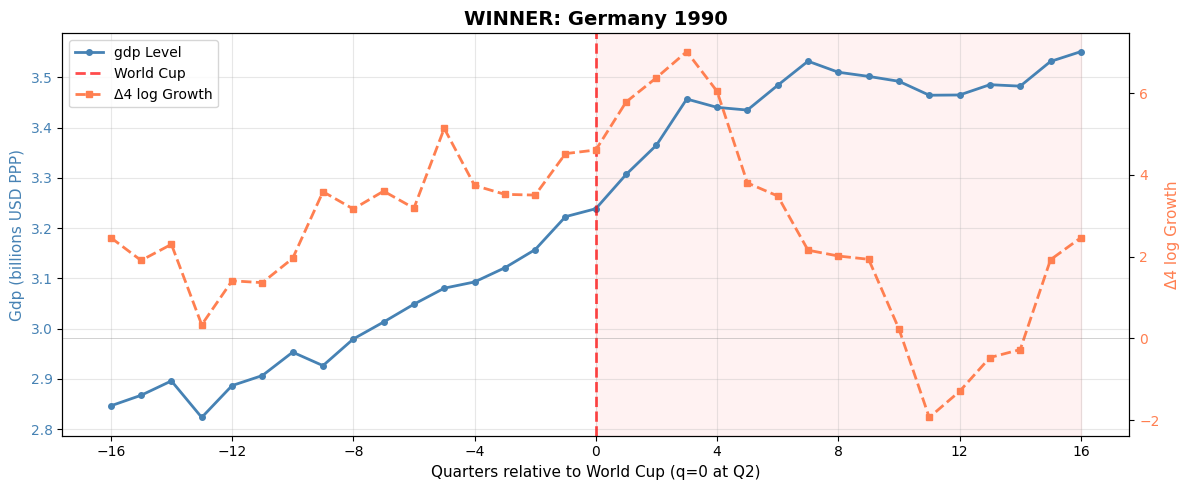


Insufficient data for WINNER: Brazil 1994

Saved: ../mello_paper_replication/event_study_plots\winner_FRA_1998.png


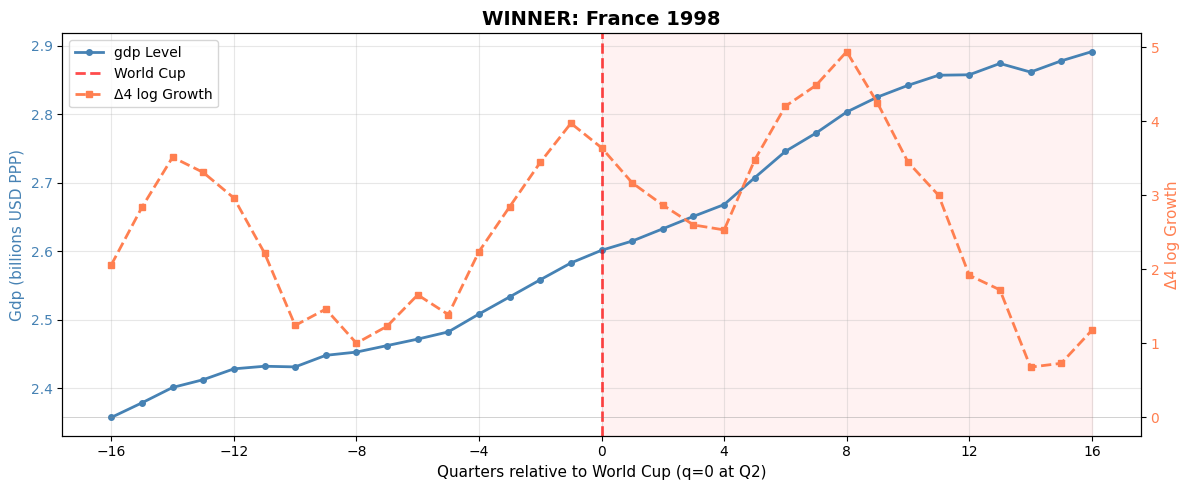


Saved: ../mello_paper_replication/event_study_plots\winner_BRA_2002.png


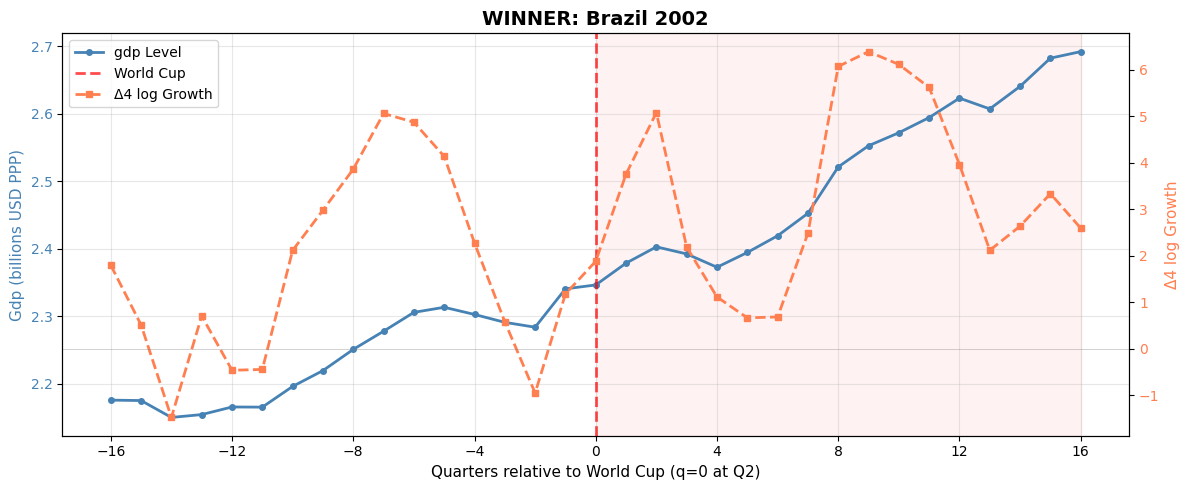


Saved: ../mello_paper_replication/event_study_plots\winner_ITA_2006.png


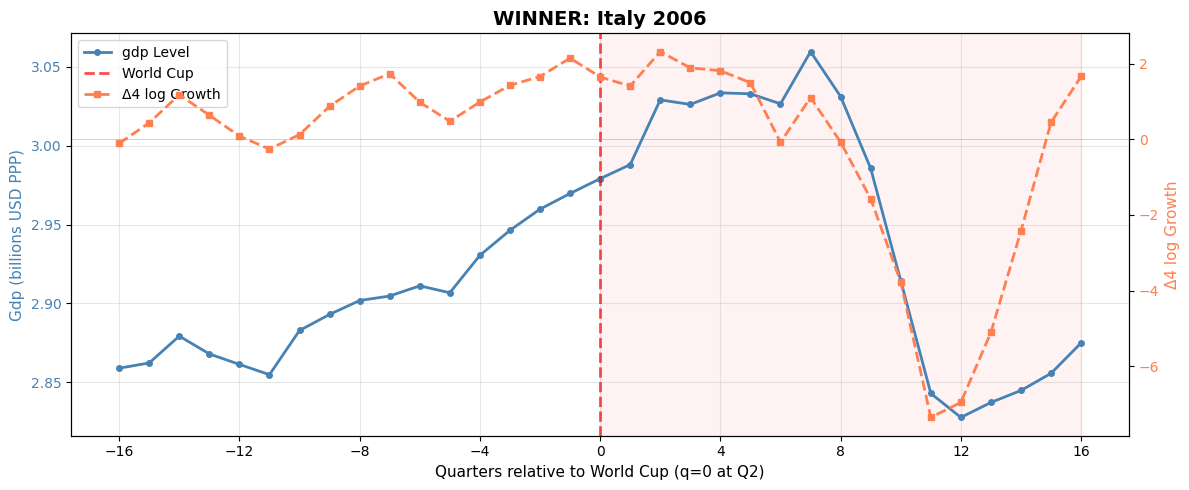


Saved: ../mello_paper_replication/event_study_plots\winner_ESP_2010.png


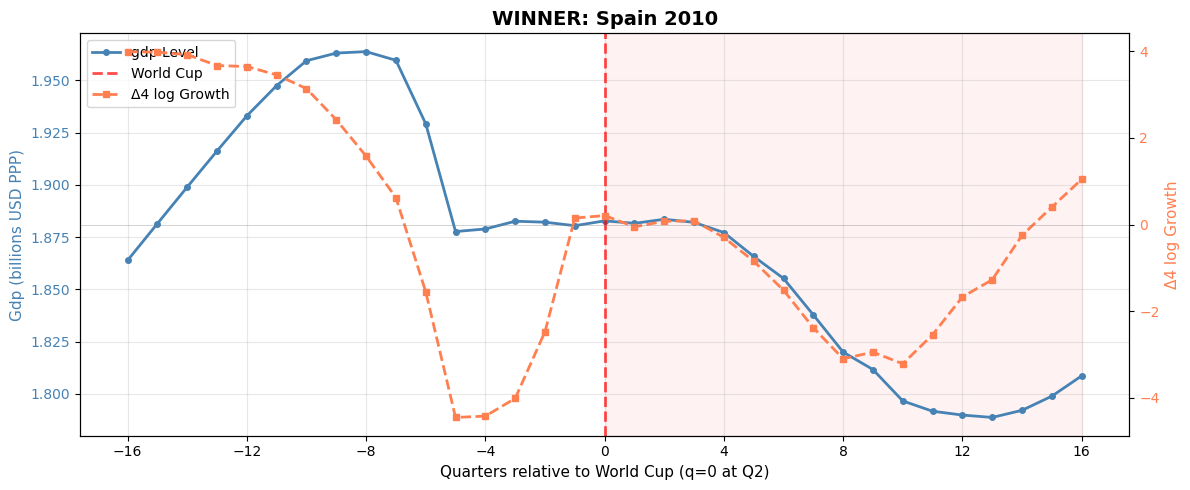


Saved: ../mello_paper_replication/event_study_plots\winner_DEU_2014.png


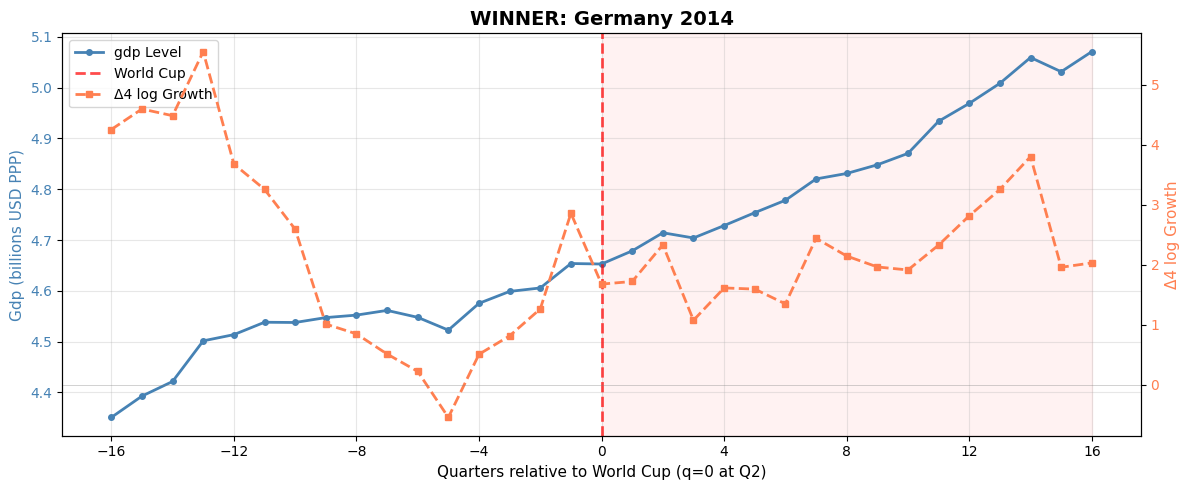


Saved: ../mello_paper_replication/event_study_plots\winner_FRA_2018.png


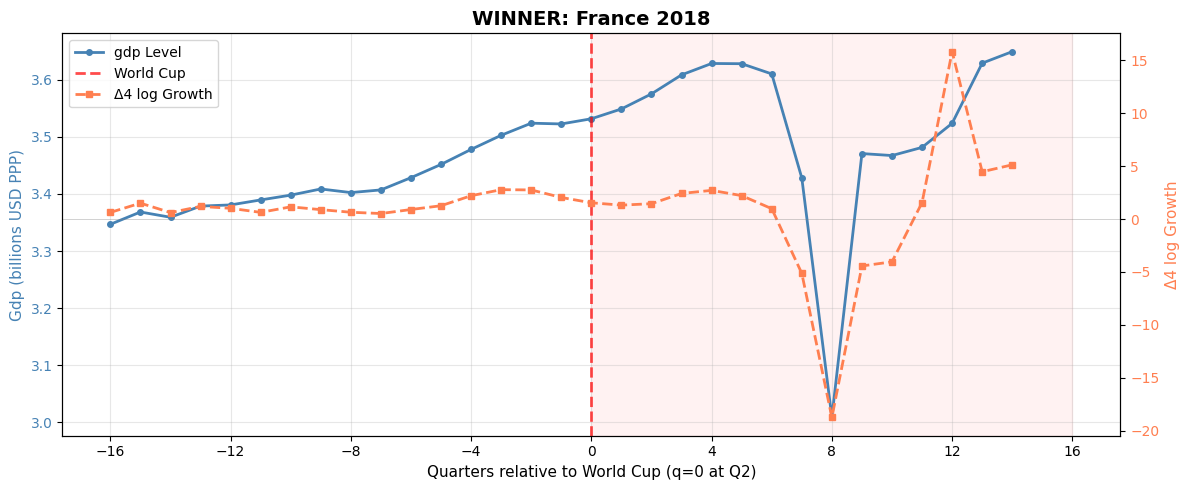

In [ ]:
# Plot each World Cup winner (GDP only)
print("=" * 60)
print("WORLD CUP WINNERS: GDP and YoY Growth (±16 quarters)")
print("=" * 60)

for country, year, title in winners:
    filename = f"winner_{country}_{year}.png"
    save_path = os.path.join(DESCRIPTIVE_DIR, filename)
    fig = plot_event(df, country, year, f"WINNER: {title}", gdp_col, yoy_col, save_path=save_path)
    if fig:
        plt.show()
        plt.close(fig)
    print()


## World Cup Hosts

WORLD CUP HOSTS: GDP and YoY Growth (±16 quarters)
Saved: ../mello_paper_replication/event_study_plots\host_GBR_1966.png


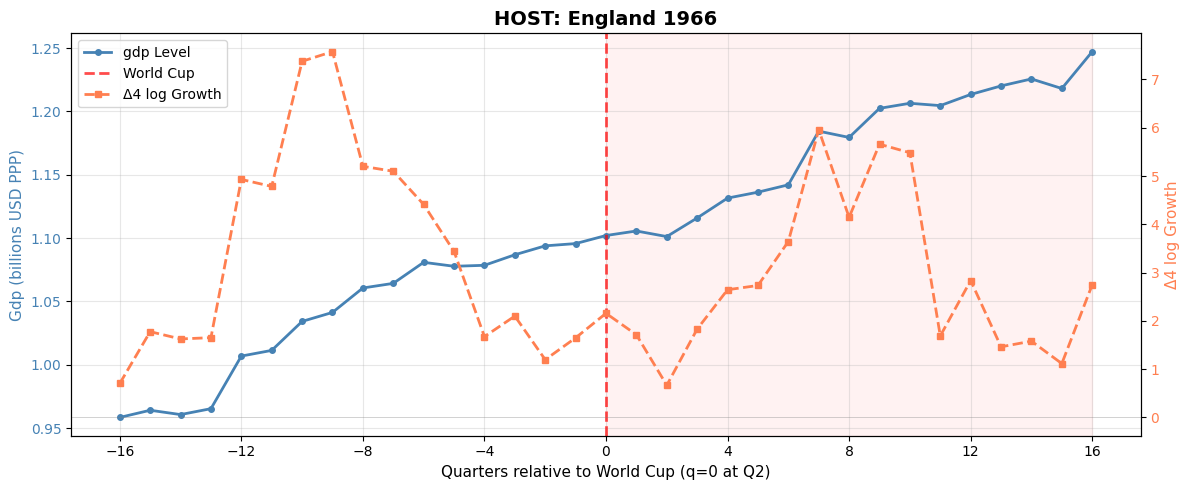


Saved: ../mello_paper_replication/event_study_plots\host_MEX_1970.png


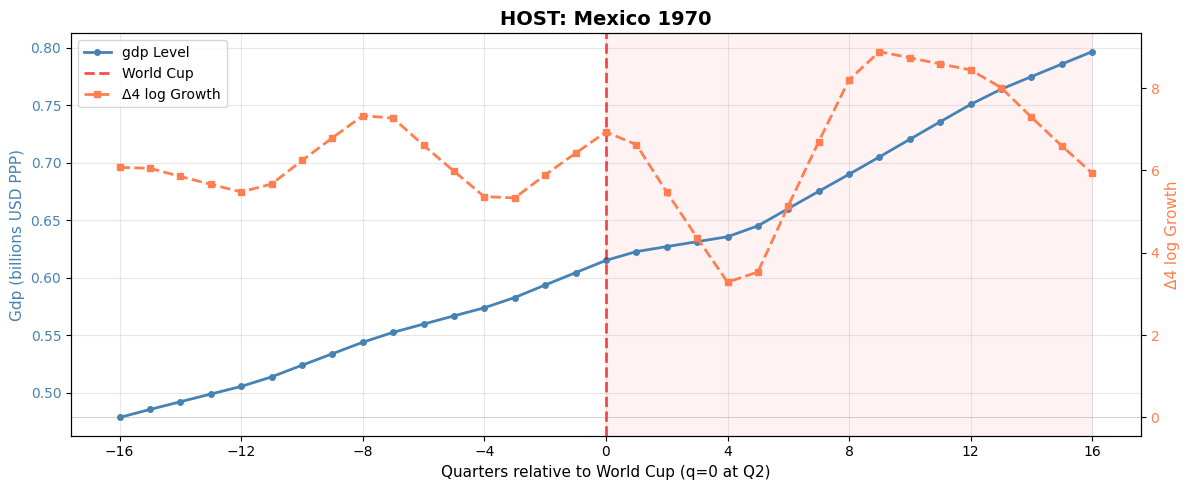


Saved: ../mello_paper_replication/event_study_plots\host_DEU_1974.png


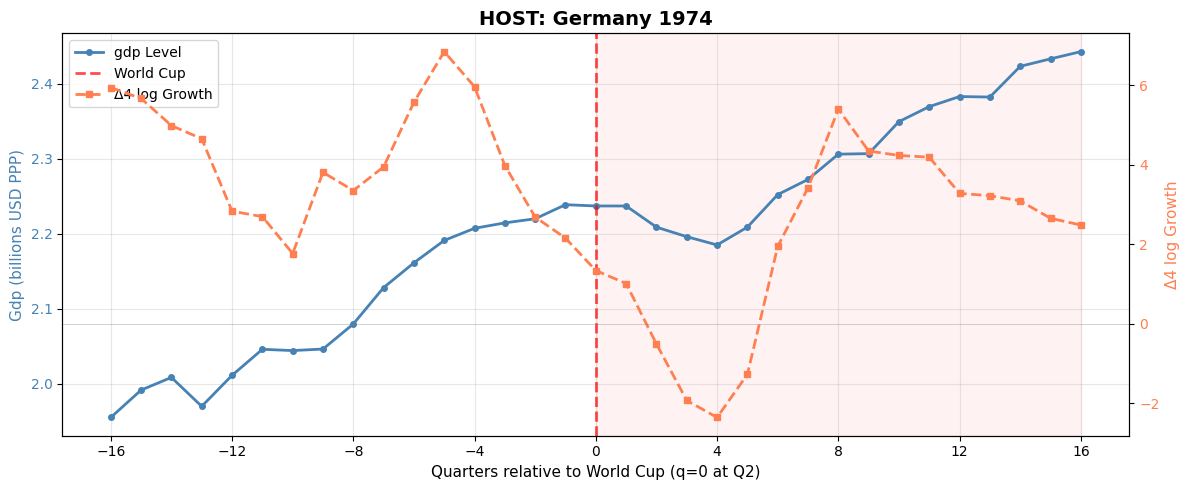


Insufficient data for HOST: Argentina 1978

Saved: ../mello_paper_replication/event_study_plots\host_ESP_1982.png


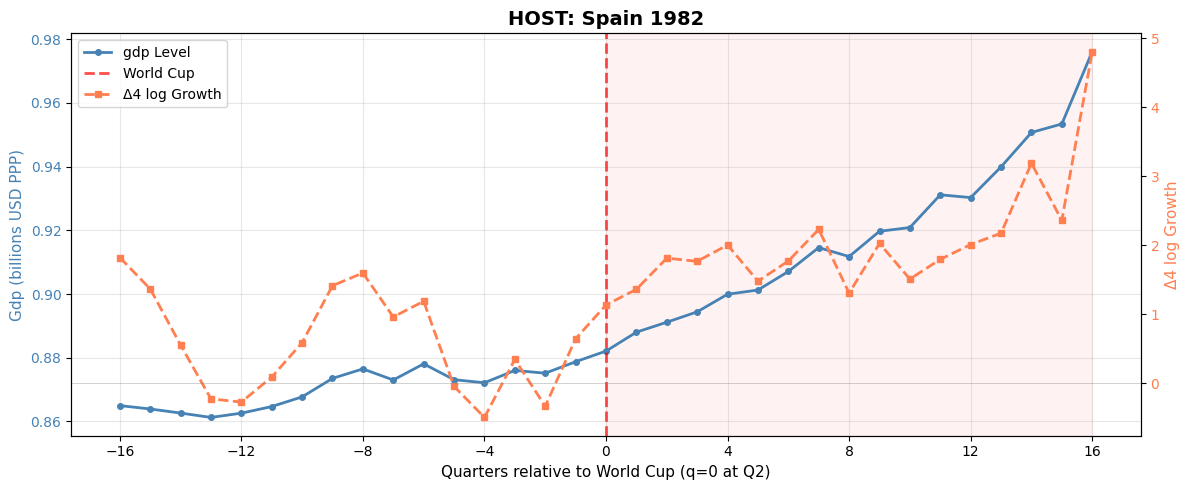


Saved: ../mello_paper_replication/event_study_plots\host_MEX_1986.png


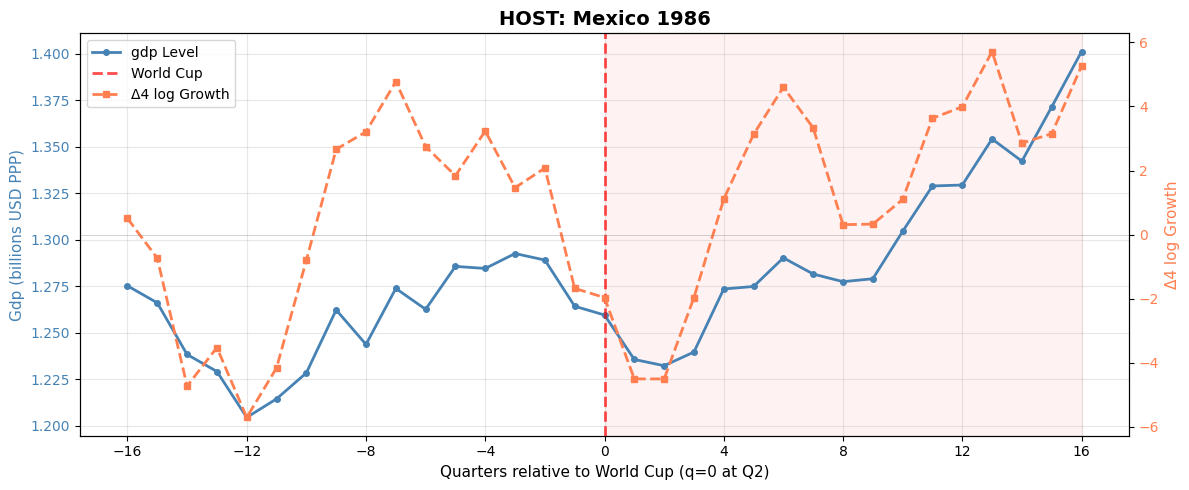


Saved: ../mello_paper_replication/event_study_plots\host_ITA_1990.png


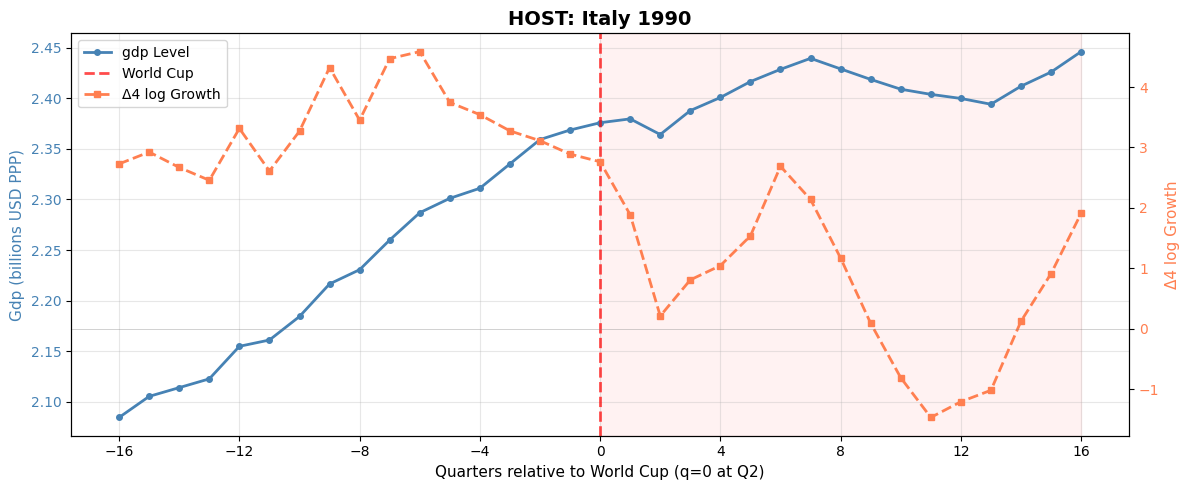


Saved: ../mello_paper_replication/event_study_plots\host_USA_1994.png


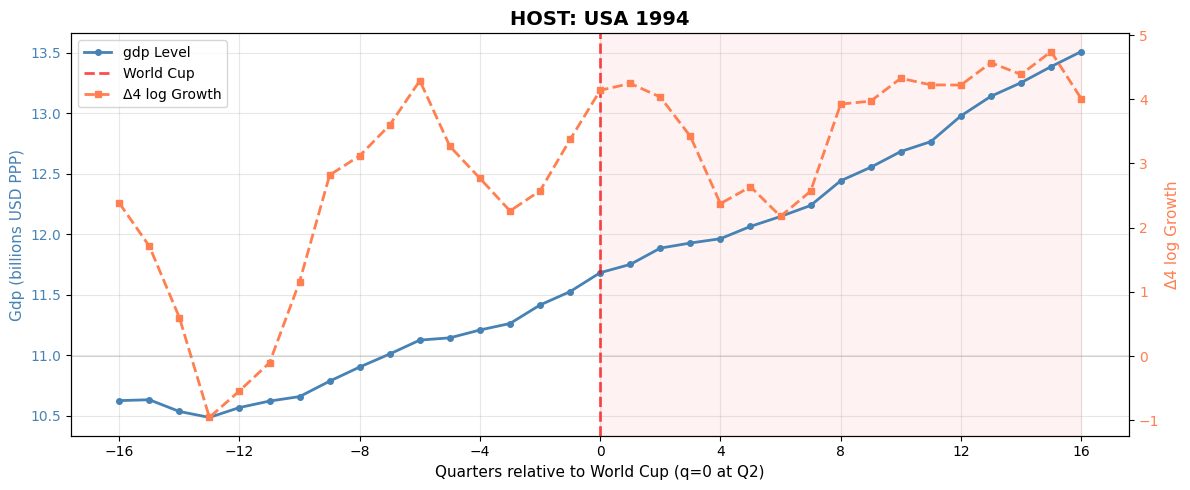


Saved: ../mello_paper_replication/event_study_plots\host_FRA_1998.png


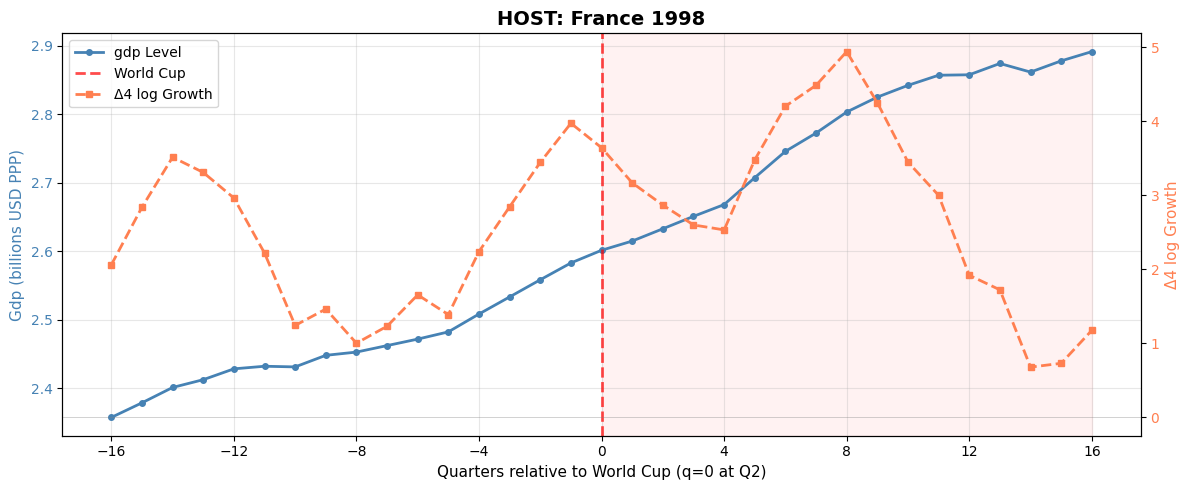


Saved: ../mello_paper_replication/event_study_plots\host_JPN_2002.png


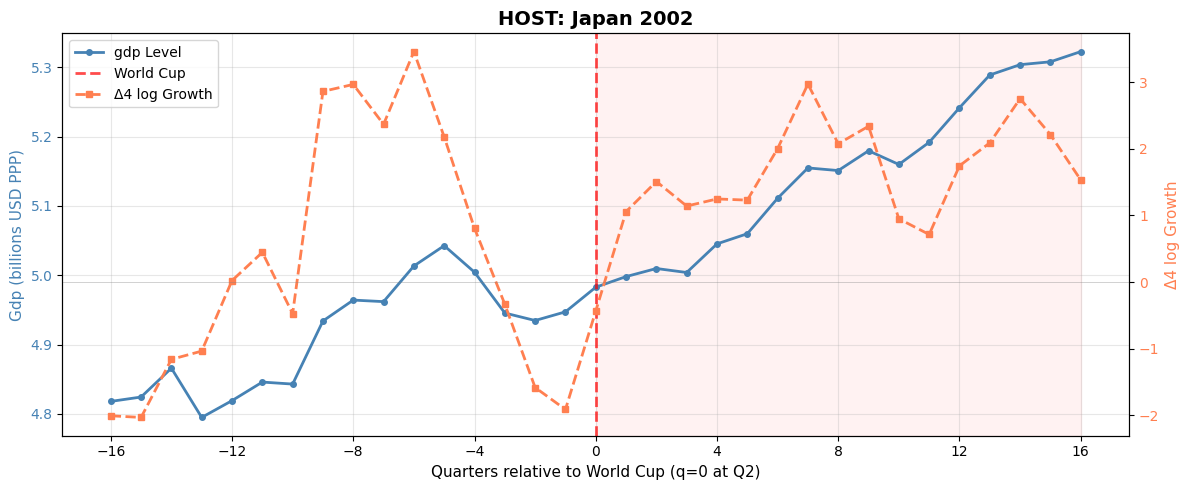


Saved: ../mello_paper_replication/event_study_plots\host_KOR_2002.png


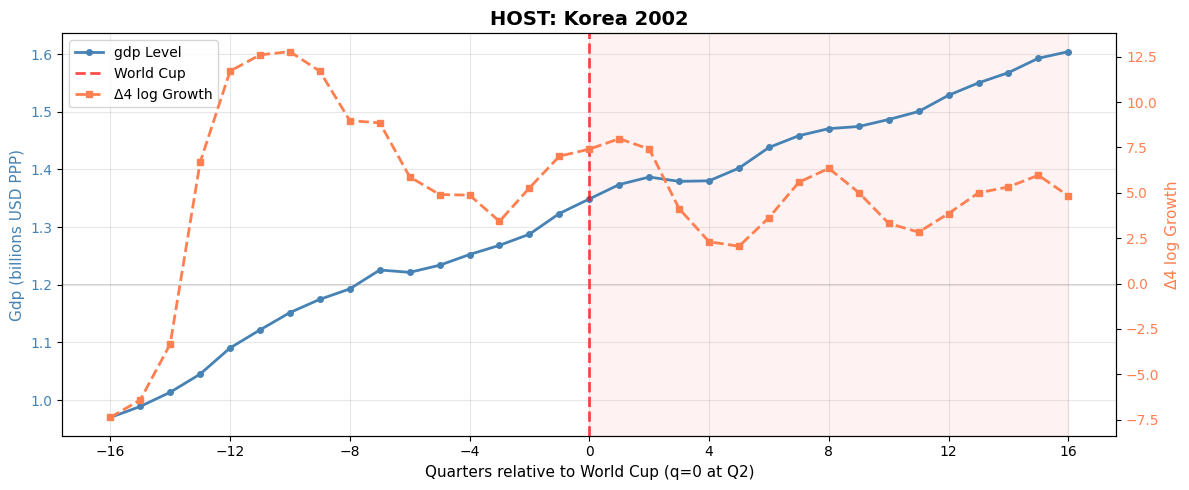


Saved: ../mello_paper_replication/event_study_plots\host_DEU_2006.png


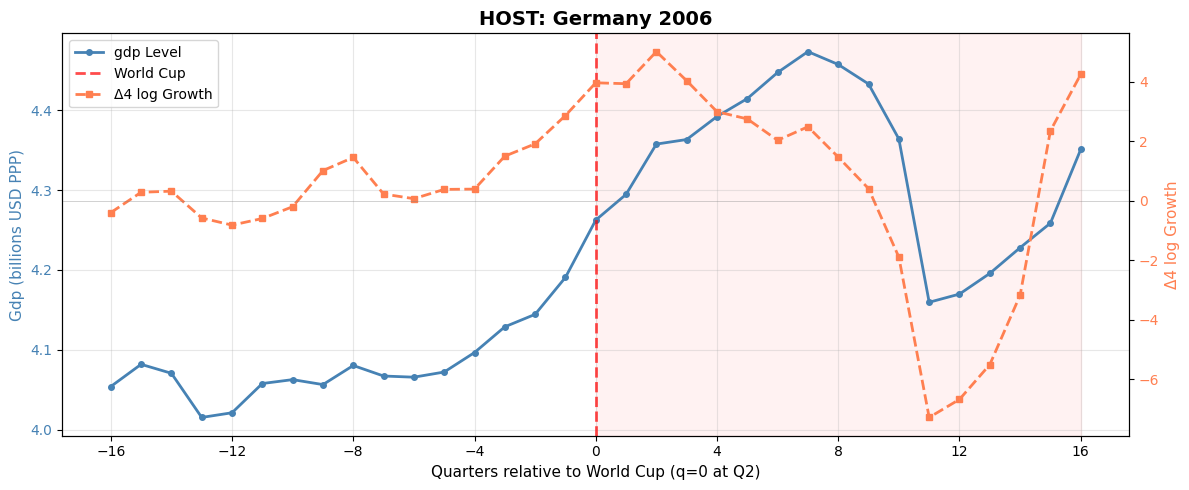


Saved: ../mello_paper_replication/event_study_plots\host_ZAF_2010.png


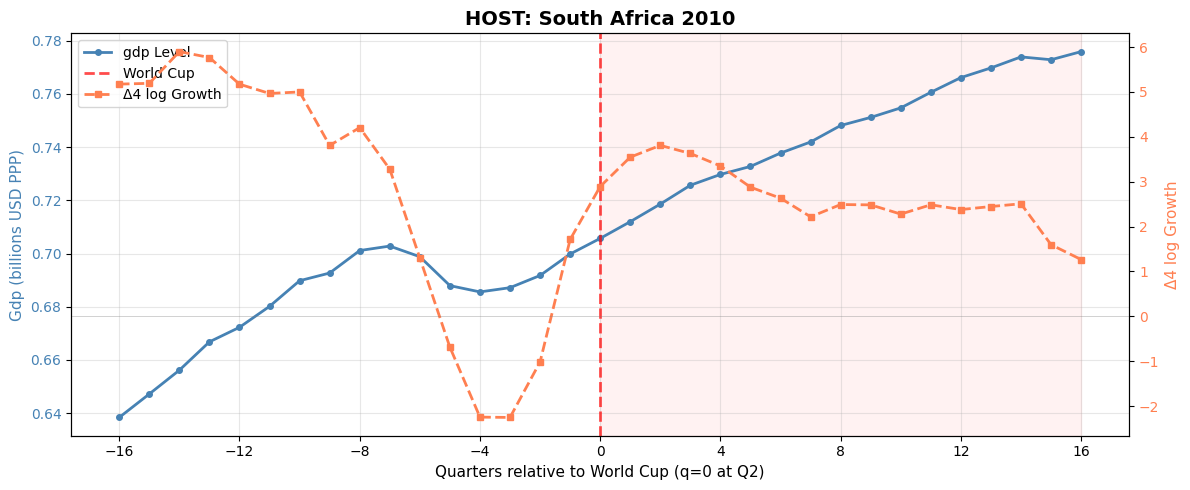


Saved: ../mello_paper_replication/event_study_plots\host_BRA_2014.png


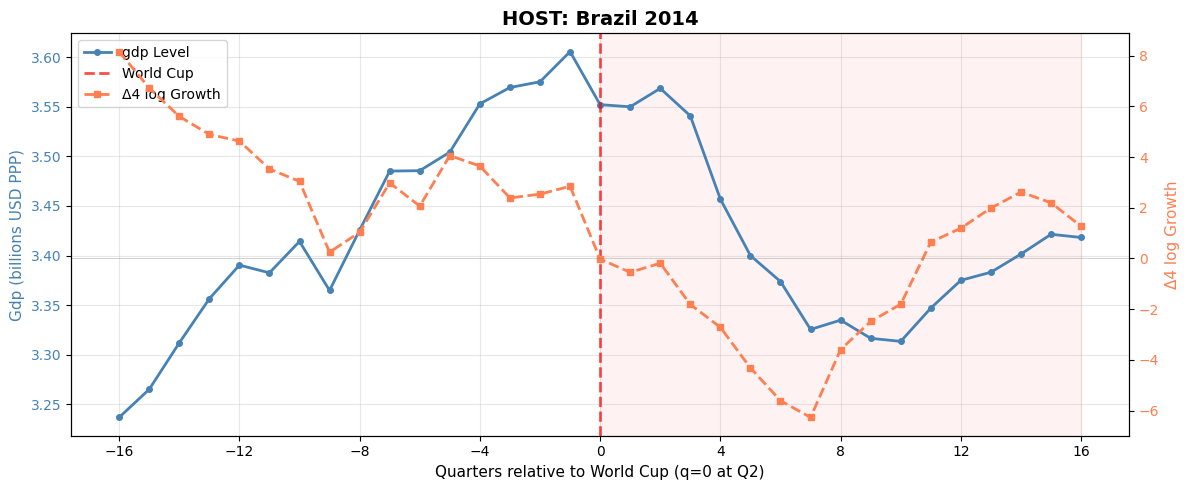


Saved: ../mello_paper_replication/event_study_plots\host_RUS_2018.png


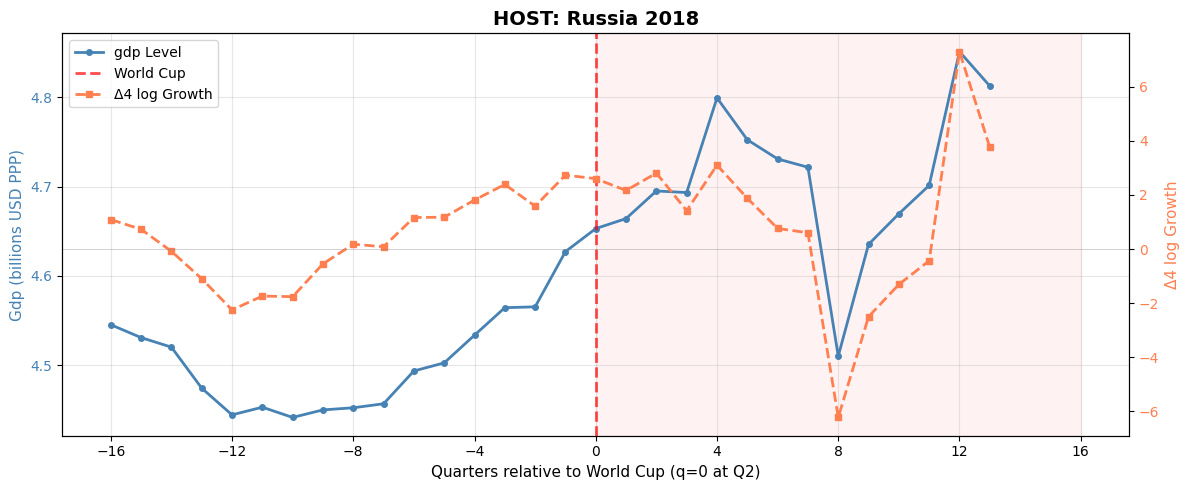

In [ ]:
# Plot each World Cup host (GDP only)
print("=" * 60)
print("WORLD CUP HOSTS: GDP and YoY Growth (±16 quarters)")
print("=" * 60)

for country, year, title in hosts:
    filename = f"host_{country}_{year}.png"
    save_path = os.path.join(DESCRIPTIVE_DIR, filename)
    fig = plot_event(df, country, year, f"HOST: {title}", gdp_col, yoy_col, save_path=save_path)
    if fig:
        plt.show()
        plt.close(fig)
    print()


## Summary: Average Patterns

In [7]:
# Compute average YoY growth pattern across all winners and hosts

def extract_event_series(df, events, level_col, yoy_col, window=16):
    """Extract normalized series for each event."""
    all_series = []
    
    for country, year, title in events:
        event_tq = year * 4 + 2
        country_df = df[df['country'] == country].copy()
        
        if len(country_df) == 0:
            continue
            
        country_df['rel_time'] = country_df['tq'] - event_tq
        event_df = country_df[(country_df['rel_time'] >= -window) & (country_df['rel_time'] <= window)].copy()
        
        if len(event_df) < 20:
            continue
            
        event_df['event_label'] = title
        all_series.append(event_df[['rel_time', yoy_col, level_col, 'event_label']])
    
    if all_series:
        return pd.concat(all_series, ignore_index=True)
    return pd.DataFrame()

# Extract series
winners_df = extract_event_series(df, winners, gdp_col, yoy_col)
hosts_df = extract_event_series(df, hosts, gdp_col, yoy_col)

print(f"Winner events with full data: {winners_df['event_label'].nunique()}")
print(f"Host events with full data: {hosts_df['event_label'].nunique()}")

Winner events with full data: 10
Host events with full data: 14


Saved: ../mello_paper_replication/event_study_plots/summary_avg_winners_vs_hosts.png


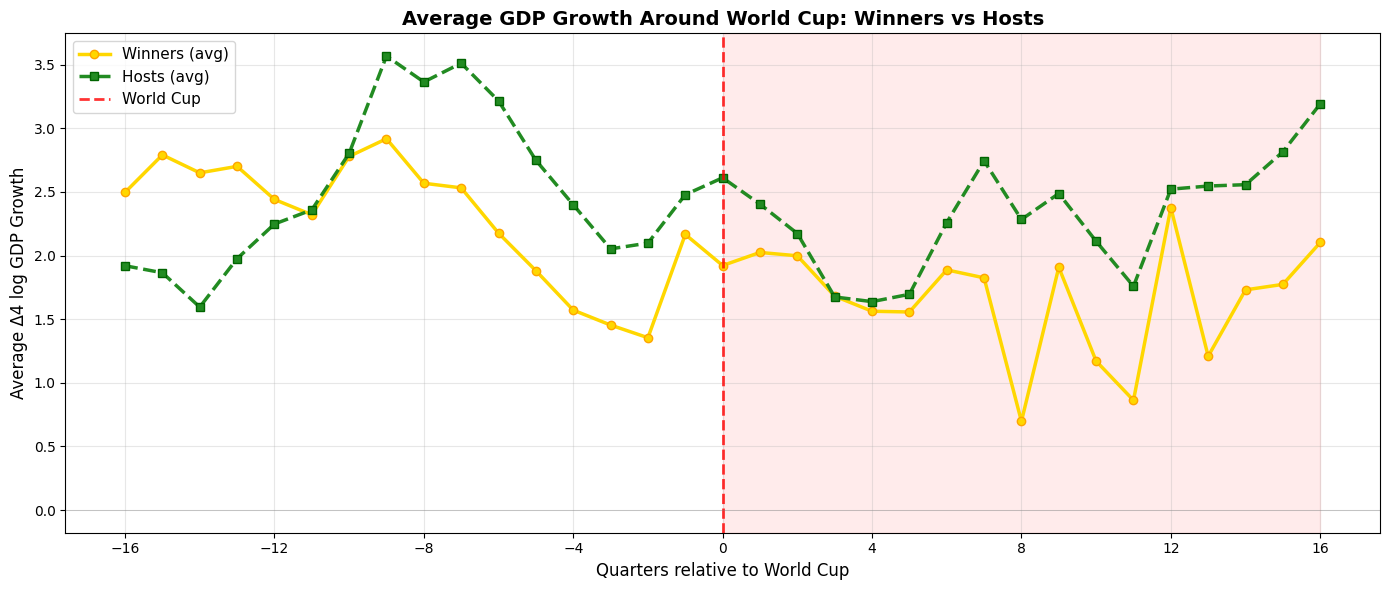

In [ ]:
# Average Δ4 log GDP growth by relative time: Winners vs Hosts

fig, ax = plt.subplots(figsize=(14, 6))

# Winners average
if len(winners_df) > 0:
    winners_avg = winners_df.groupby('rel_time')[yoy_col].mean()
    ax.plot(winners_avg.index, winners_avg.values, 'o-', color='gold', linewidth=2.5, 
            markersize=6, label='Winners (avg)', markeredgecolor='orange')

# Hosts average
if len(hosts_df) > 0:
    hosts_avg = hosts_df.groupby('rel_time')[yoy_col].mean()
    ax.plot(hosts_avg.index, hosts_avg.values, 's--', color='forestgreen', linewidth=2.5, 
            markersize=6, label='Hosts (avg)', markeredgecolor='darkgreen')

# World Cup marker
ax.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.8, label='World Cup')
ax.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

# Shade post-event
ax.axvspan(0, 16, alpha=0.08, color='red')

ax.set_xlabel('Quarters relative to World Cup', fontsize=12)
ax.set_ylabel('Average Δ4 log GDP Growth', fontsize=12)
ax.set_title('Average GDP Growth Around World Cup: Winners vs Hosts', fontsize=14, fontweight='bold')
ax.set_xticks(range(-16, 17, 4))
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(os.path.join(DESCRIPTIVE_DIR, 'summary_avg_winners_vs_hosts.png'), dpi=150, bbox_inches='tight')
print(f"Saved: {DESCRIPTIVE_DIR}/summary_avg_winners_vs_hosts.png")
plt.show()
plt.close(fig)

Saved: ../mello_paper_replication/event_study_plots/summary_all_winners_overlay.png


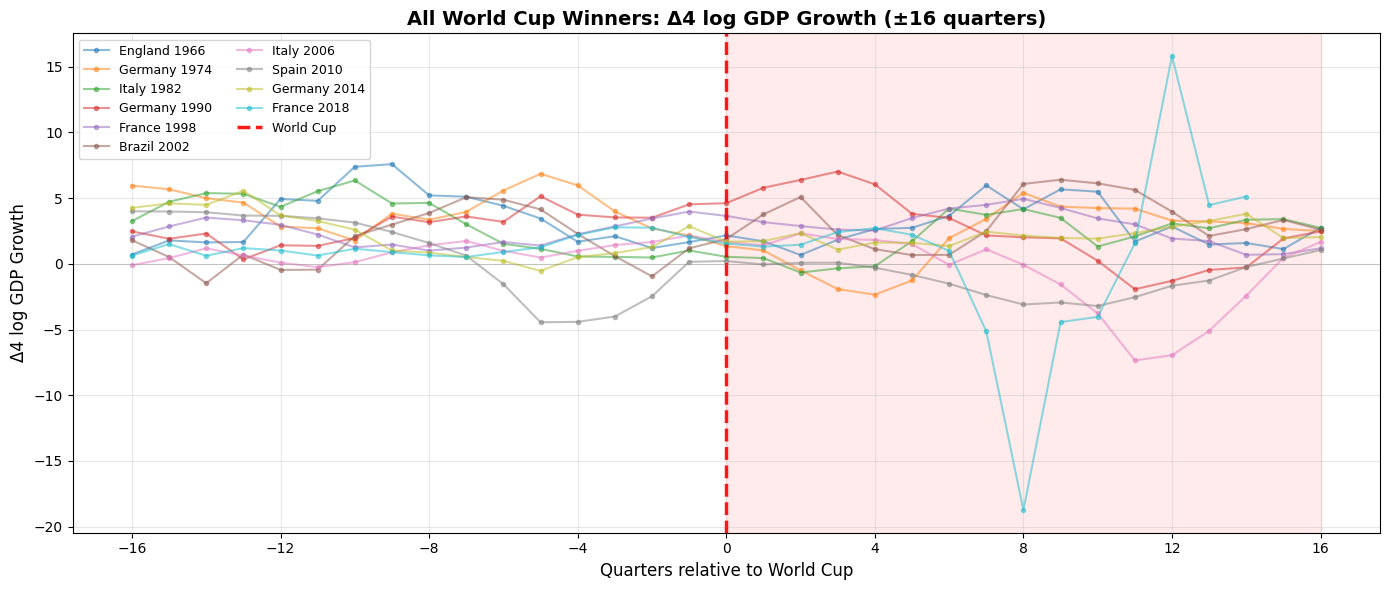

In [ ]:
# All winner events overlaid (Δ4 log GDP growth)

fig, ax = plt.subplots(figsize=(14, 6))

for event_label in winners_df['event_label'].unique():
    event_data = winners_df[winners_df['event_label'] == event_label]
    ax.plot(event_data['rel_time'], event_data[yoy_col], 'o-', alpha=0.5, linewidth=1.5, 
            markersize=3, label=event_label)

ax.axvline(0, color='red', linestyle='--', linewidth=2.5, alpha=0.9, label='World Cup')
ax.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
ax.axvspan(0, 16, alpha=0.08, color='red')

ax.set_xlabel('Quarters relative to World Cup', fontsize=12)
ax.set_ylabel('Δ4 log GDP Growth', fontsize=12)
ax.set_title('All World Cup Winners: Δ4 log GDP Growth (±16 quarters)', fontsize=14, fontweight='bold')
ax.set_xticks(range(-16, 17, 4))
ax.legend(loc='upper left', fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(os.path.join(DESCRIPTIVE_DIR, 'summary_all_winners_overlay.png'), dpi=150, bbox_inches='tight')
print(f"Saved: {DESCRIPTIVE_DIR}/summary_all_winners_overlay.png")
plt.show()
plt.close(fig)

Saved: ../mello_paper_replication/event_study_plots/summary_all_hosts_overlay.png


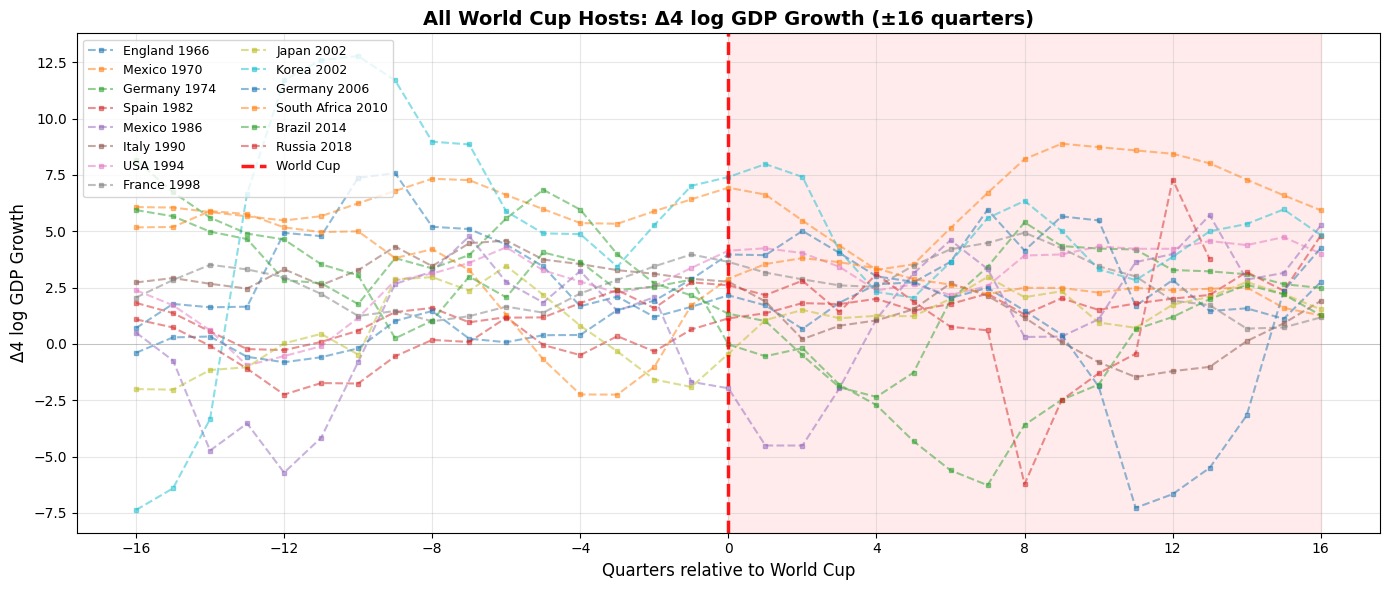

In [ ]:
# All host events overlaid (Δ4 log GDP growth)

fig, ax = plt.subplots(figsize=(14, 6))

for event_label in hosts_df['event_label'].unique():
    event_data = hosts_df[hosts_df['event_label'] == event_label]
    ax.plot(event_data['rel_time'], event_data[yoy_col], 's--', alpha=0.5, linewidth=1.5, 
            markersize=3, label=event_label)

ax.axvline(0, color='red', linestyle='--', linewidth=2.5, alpha=0.9, label='World Cup')
ax.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
ax.axvspan(0, 16, alpha=0.08, color='red')

ax.set_xlabel('Quarters relative to World Cup', fontsize=12)
ax.set_ylabel('Δ4 log GDP Growth', fontsize=12)
ax.set_title('All World Cup Hosts: Δ4 log GDP Growth (±16 quarters)', fontsize=14, fontweight='bold')
ax.set_xticks(range(-16, 17, 4))
ax.legend(loc='upper left', fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(os.path.join(DESCRIPTIVE_DIR, 'summary_all_hosts_overlay.png'), dpi=150, bbox_inches='tight')
print(f"Saved: {DESCRIPTIVE_DIR}/summary_all_hosts_overlay.png")
plt.show()
plt.close(fig)

## Summary: All Features — Winner Overlays & Averages

Saved: ../mello_paper_replication/event_study_plots\summary_winners_gdp_overlay.png


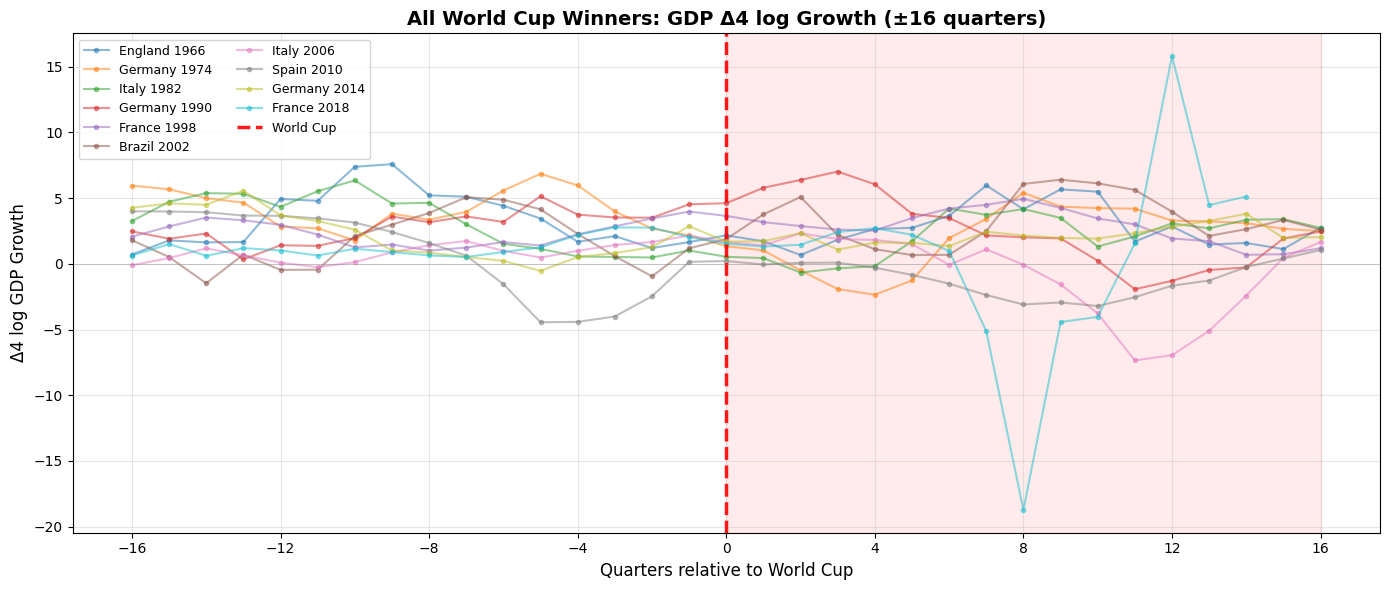

Saved: ../mello_paper_replication/event_study_plots\summary_winners_private_consumption_overlay.png


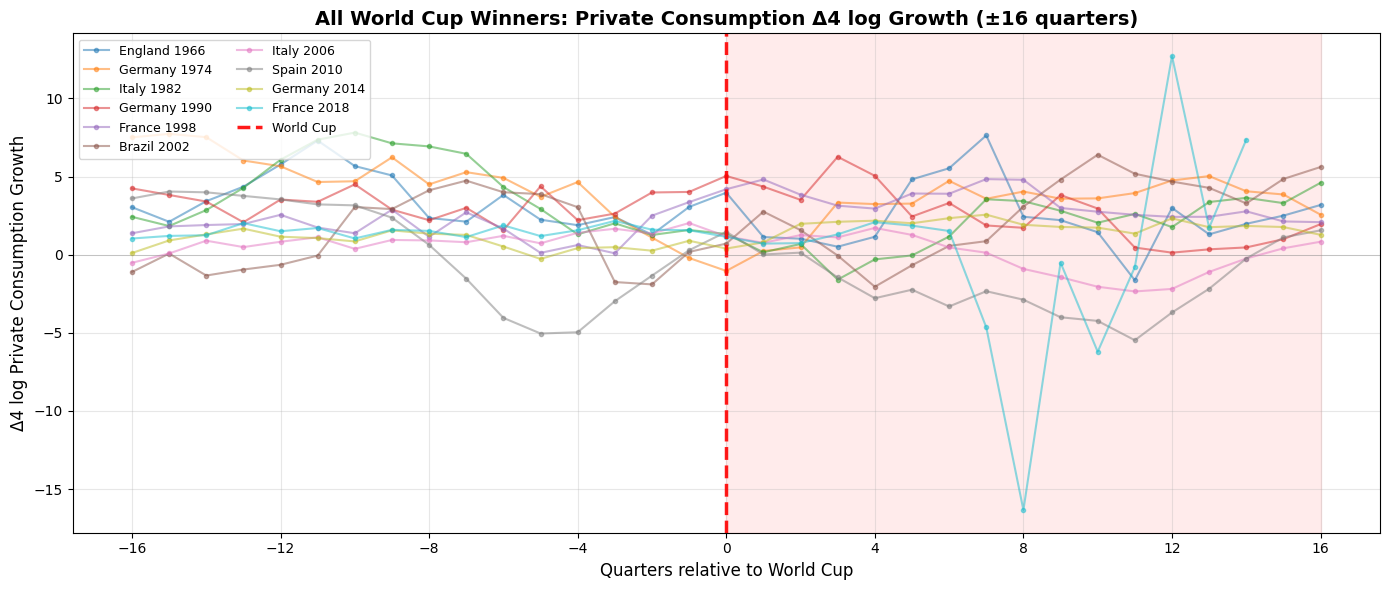

Saved: ../mello_paper_replication/event_study_plots\summary_winners_government_consumption_overlay.png


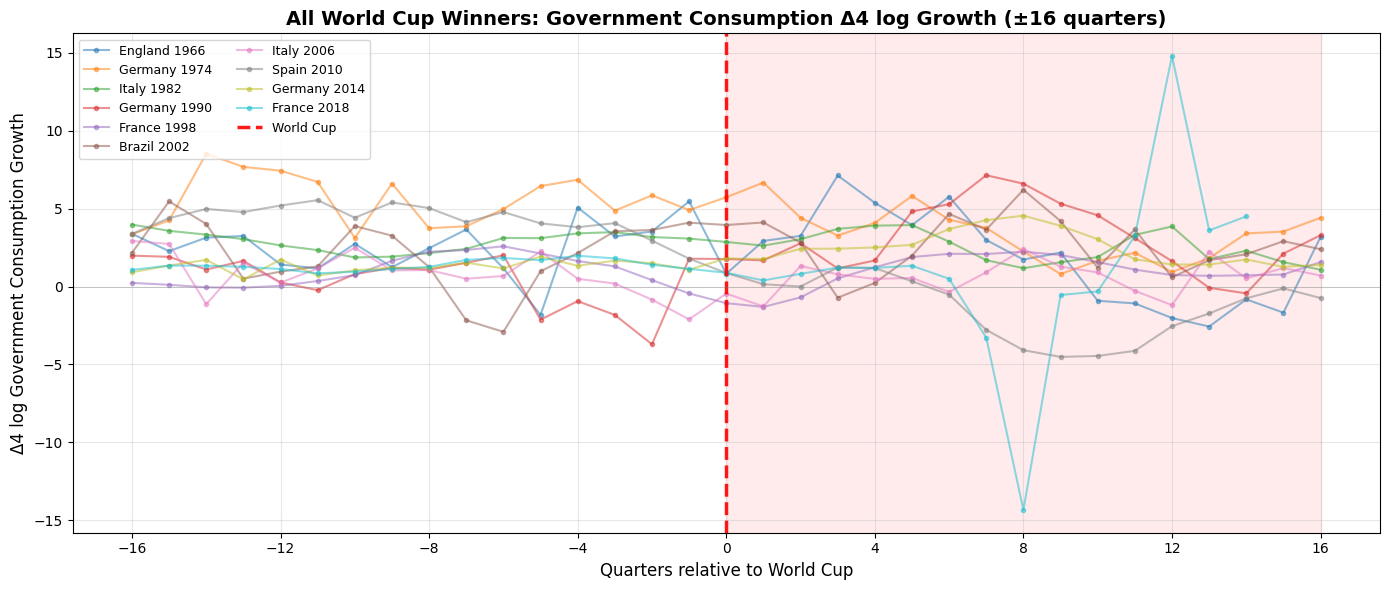

Saved: ../mello_paper_replication/event_study_plots\summary_winners_investment_overlay.png


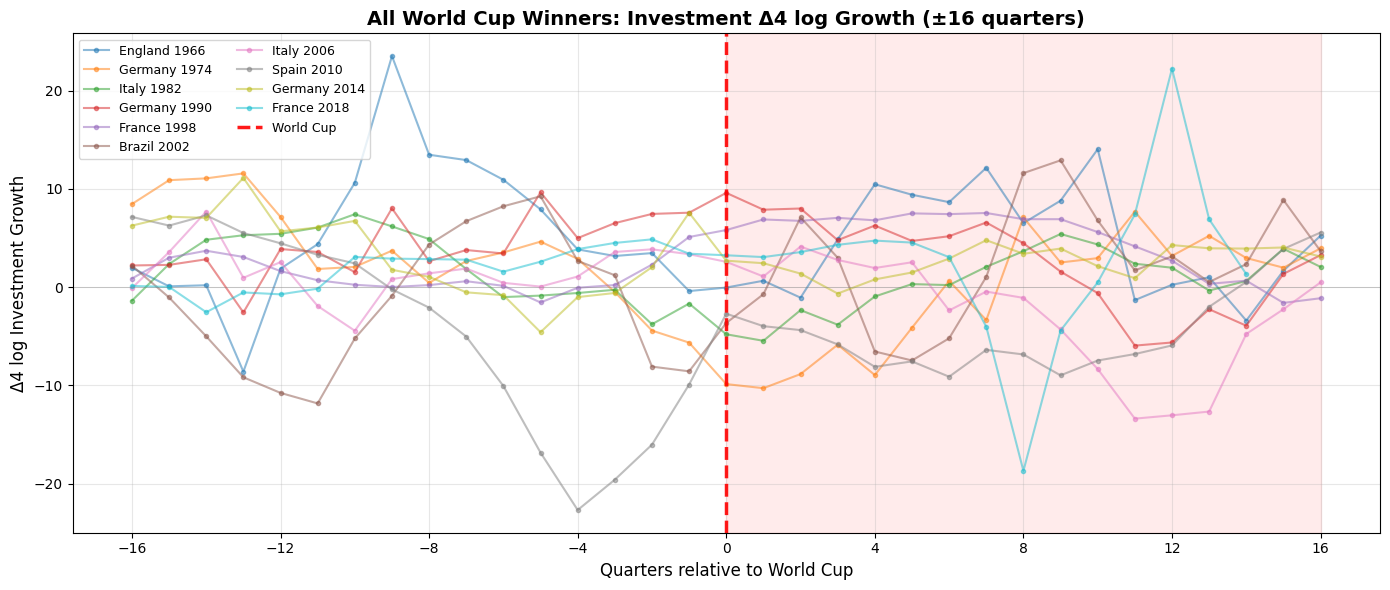

Saved: ../mello_paper_replication/event_study_plots\summary_winners_exports_overlay.png


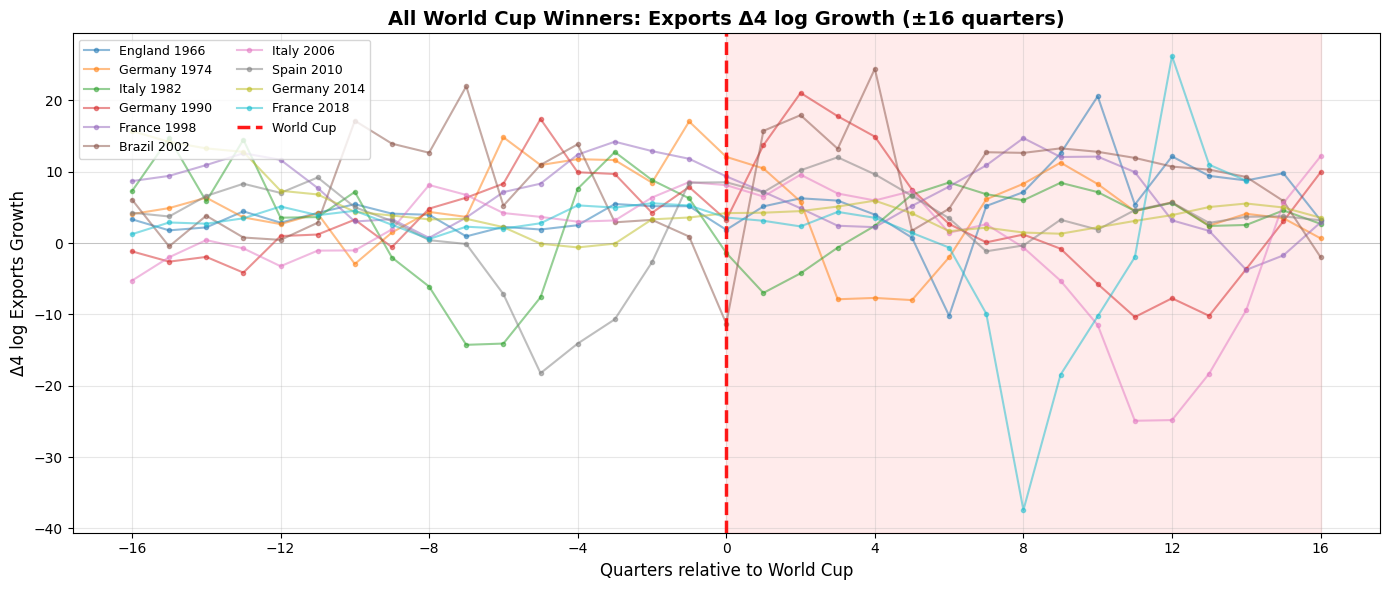

Saved: ../mello_paper_replication/event_study_plots\summary_winners_imports_overlay.png


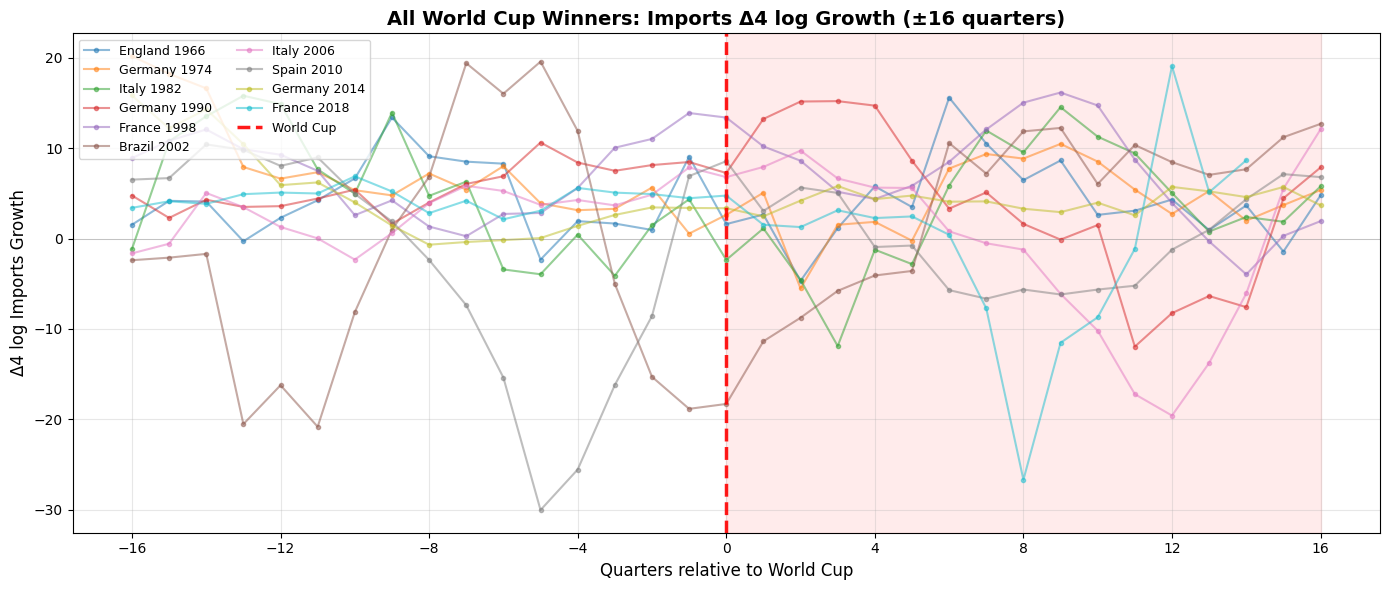

In [ ]:
# Overlay plots: All winners for each feature (Δ4 log growth)

for level_col, yoy_col_feat, feature_name in FEATURES:
    
    # Extract series for this feature
    feat_df = extract_event_series(df, winners, level_col, yoy_col_feat)
    
    if len(feat_df) == 0:
        print(f"No data for {feature_name}")
        continue
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    for event_label in feat_df['event_label'].unique():
        event_data = feat_df[feat_df['event_label'] == event_label]
        ax.plot(event_data['rel_time'], event_data[yoy_col_feat], 'o-', alpha=0.5, 
                linewidth=1.5, markersize=3, label=event_label)
    
    ax.axvline(0, color='red', linestyle='--', linewidth=2.5, alpha=0.9, label='World Cup')
    ax.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.axvspan(0, 16, alpha=0.08, color='red')
    
    ax.set_xlabel('Quarters relative to World Cup', fontsize=12)
    ax.set_ylabel(f'Δ4 log {feature_name} Growth', fontsize=12)
    ax.set_title(f'All World Cup Winners: {feature_name} Δ4 log Growth (±16 quarters)', 
                fontsize=14, fontweight='bold')
    ax.set_xticks(range(-16, 17, 4))
    ax.legend(loc='upper left', fontsize=9, ncol=2)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_path = os.path.join(DESCRIPTIVE_DIR, f'summary_winners_{feature_name.lower().replace(" ", "_")}_overlay.png')
    fig.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Saved: {save_path}")
    plt.show()
    plt.close(fig)

## Summary: Average YoY Growth by Feature (Winners)

Saved: ../mello_paper_replication/event_study_plots\summary_winners_all_features_avg.png


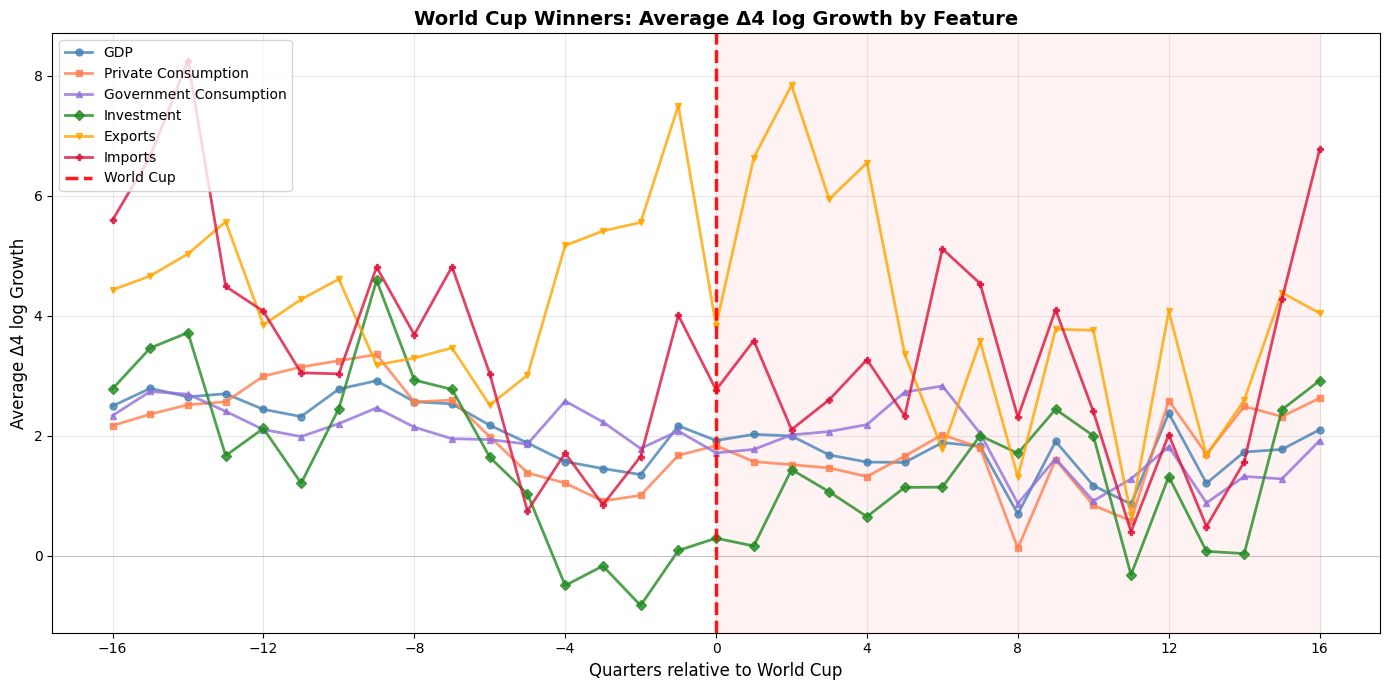

In [ ]:
# Combined plot: Average Δ4 log growth for all features (Winners)

fig, ax = plt.subplots(figsize=(14, 7))

colors = ['steelblue', 'coral', 'mediumpurple', 'forestgreen', 'orange', 'crimson']
markers = ['o', 's', '^', 'D', 'v', 'P']

for i, (level_col, yoy_col_feat, feature_name) in enumerate(FEATURES):
    
    feat_df = extract_event_series(df, winners, level_col, yoy_col_feat)
    
    if len(feat_df) == 0:
        continue
    
    avg_series = feat_df.groupby('rel_time')[yoy_col_feat].mean()
    
    ax.plot(avg_series.index, avg_series.values, f'{markers[i]}-', 
            color=colors[i], linewidth=2, markersize=5, 
            label=f'{feature_name}', alpha=0.8)

ax.axvline(0, color='red', linestyle='--', linewidth=2.5, alpha=0.9, label='World Cup')
ax.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
ax.axvspan(0, 16, alpha=0.05, color='red')

ax.set_xlabel('Quarters relative to World Cup', fontsize=12)
ax.set_ylabel('Average Δ4 log Growth', fontsize=12)
ax.set_title('World Cup Winners: Average Δ4 log Growth by Feature', fontsize=14, fontweight='bold')
ax.set_xticks(range(-16, 17, 4))
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
save_path = os.path.join(DESCRIPTIVE_DIR, 'summary_winners_all_features_avg.png')
fig.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()
plt.close(fig)

In [ ]:
# List all saved plots
for dir_label, dir_path in [("EVENT STUDY PLOTS", EVENT_STUDY_DIR), ("DESCRIPTIVE PLOTS", DESCRIPTIVE_DIR)]:
    print("=" * 60)
    print(dir_label)
    print("=" * 60)
    if os.path.exists(dir_path):
        saved_files = sorted([f for f in os.listdir(dir_path) if f.endswith('.png')])
        print(f"Total: {len(saved_files)} plots saved to '{dir_path}/'")
        print()
        for f in saved_files:
            print(f"  {f}")
    else:
        print(f"Directory '{dir_path}/' not found")
    print()

ALL SAVED PLOTS
Total: 34 plots saved to '../mello_paper_replication/event_study_plots/'

  host_BRA_2014.png
  host_DEU_1974.png
  host_DEU_2006.png
  host_ESP_1982.png
  host_FRA_1998.png
  host_GBR_1966.png
  host_ITA_1990.png
  host_JPN_2002.png
  host_KOR_2002.png
  host_MEX_1970.png
  host_MEX_1986.png
  host_RUS_2018.png
  host_USA_1994.png
  host_ZAF_2010.png
  summary_all_hosts_overlay.png
  summary_all_winners_overlay.png
  summary_avg_winners_vs_hosts.png
  summary_winners_all_features_avg.png
  summary_winners_exports_overlay.png
  summary_winners_gdp_overlay.png
  summary_winners_government_consumption_overlay.png
  summary_winners_imports_overlay.png
  summary_winners_investment_overlay.png
  summary_winners_private_consumption_overlay.png
  winner_BRA_2002.png
  winner_DEU_1974.png
  winner_DEU_1990.png
  winner_DEU_2014.png
  winner_ESP_2010.png
  winner_FRA_1998.png
  winner_FRA_2018.png
  winner_GBR_1966.png
  winner_ITA_1982.png
  winner_ITA_2006.png


Saved: ../../thesis/figures\last_7_winners_gdp_overlay.png


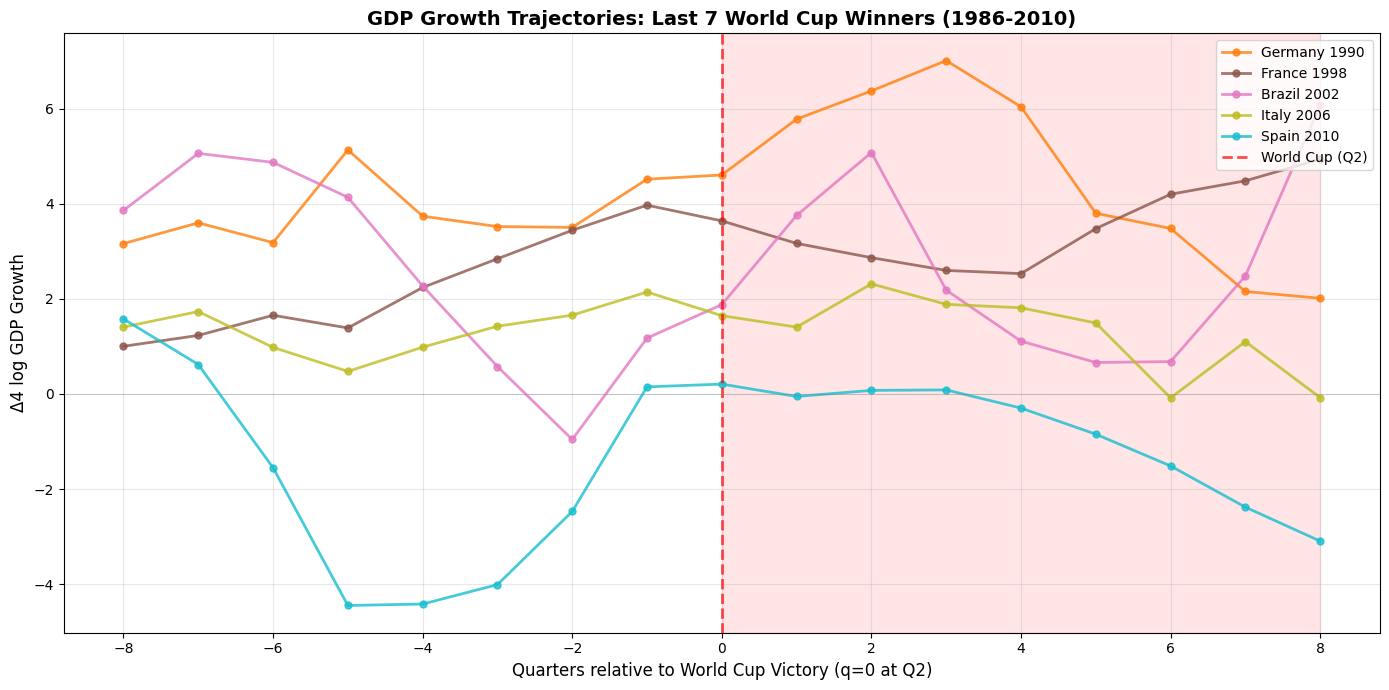

In [14]:
# =============================================================================
# Last 7 World Cup Winners (1986-2010) - as referenced in Forbes 2014 article
# =============================================================================

last_7_winners = [
    ('ARG', 1986, 'Argentina 1986'),
    ('DEU', 1990, 'Germany 1990'),
    ('BRA', 1994, 'Brazil 1994'),
    ('FRA', 1998, 'France 1998'),
    ('BRA', 2002, 'Brazil 2002'),
    ('ITA', 2006, 'Italy 2006'),
    ('ESP', 2010, 'Spain 2010'),
]

fig, ax = plt.subplots(figsize=(14, 7))
colors = plt.cm.tab10(np.linspace(0, 1, len(last_7_winners)))

for i, (country, year, title) in enumerate(last_7_winners):
    country_df = df[df['country'] == country].copy()
    
    event_tq = year * 4 + 2
    country_df['rel_time'] = country_df['tq'] - event_tq
    
    window = 8
    plot_df = country_df[(country_df['rel_time'] >= -window) & 
                          (country_df['rel_time'] <= window)].copy()
    
    if len(plot_df) > 0 and yoy_col in plot_df.columns:
        ax.plot(plot_df['rel_time'], plot_df[yoy_col], 
                'o-', color=colors[i], linewidth=2, markersize=5, 
                label=title, alpha=0.8)

ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='World Cup (Q2)', alpha=0.7)
ax.axvspan(0, 8, alpha=0.1, color='red')
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

ax.set_xlabel('Quarters relative to World Cup Victory (q=0 at Q2)', fontsize=12)
ax.set_ylabel('Δ4 log GDP Growth', fontsize=12)
ax.set_title('GDP Growth Trajectories: Last 7 World Cup Winners (1986-2010)', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(-window, window+1, 2))

plt.tight_layout()

THESIS_DIR = '../../thesis/figures'
os.makedirs(THESIS_DIR, exist_ok=True)
save_path = os.path.join(THESIS_DIR, 'last_7_winners_gdp_overlay.png')
fig.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"Saved: {save_path}")

plt.show()